### Scraping Products from Amazon using Selenium

In [45]:
import selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from time import sleep

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
# instantiate a browser object
driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()))

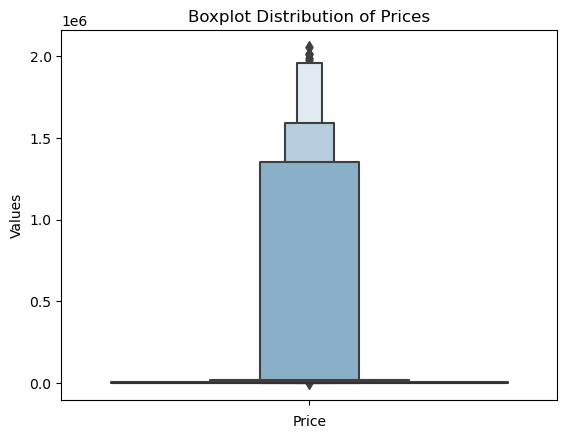

In [155]:
sns.boxenplot(data =df, y = 'Prices')
plt.title('Boxplot Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Values')

plt.show()

In [30]:
def clean_alibaba(df):
    # Remove 'NGN' and comma from price and convert to float
    def clean_price(price):
        cleaned_price = price.replace('NGN', '').replace(',', '')
        return float(cleaned_price)

    
    # Clean shipping fee column
    def clean_shipping_fee(shipping_fee):
        if shipping_fee == 'Free shipping':
            return 0.0
        elif '+Shipping' in shipping_fee:
            # Extracting the price from the string using regular expression
            price_match = re.search(r'NGN([\d,]+\.\d+)', shipping_fee)
            if price_match:
                return float(price_match.group(1).replace(',', ''))
        else:
            return None
    
    df["Shipping Prices"] = df["Shipping Prices"].apply(clean_shipping_fee)
    df['Prices'] = df['Prices'].apply(clean_price)
    
    return df


In [31]:
import re
import pandas as pd
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from time import sleep

def scrape_aliexpress(search_term, num_pages=5):
    """Scrapes product information from AliExpress for the given search term.

    Args:
       search_term (str): The product to search for.
       num_pages (int, optional): The number of pages to scrape. Defaults to 5.

    Returns:
       pd.DataFrame: A DataFrame containing the scraped product data.
    """

    browser = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install())) # Open a Chrome browser instance

    website = 'https://www.aliexpress.com'
    browser.get(website)  # Navigate to AliExpress
    browser.maximize_window()  # Maximize the window for better visibility

    # Find the search bar and button elements
    input_search = browser.find_element(By.CLASS_NAME, 'search--keyword--15P08Ji')
    search_button = browser.find_element(By.CLASS_NAME, 'search--submit--2VTbd-T')

    # Perform the search
    input_search.clear()
    input_search.send_keys(search_term)
    browser.execute_script("arguments[0].click();", search_button)
    # search_button.click()

    # XPaths for product information elements
    product_class = "//h3[@class='multi--titleText--nXeOvyr']"
    price_class = "//div[@class='multi--price-sale--U-S0jtj']"
    shipping_class = "//span[@class='tag--text--1BSEXVh tag--textStyle--3dc7wLU multi--serviceStyle--1Z6RxQ4']"
    store_name = "//a[@class='cards--storeLink--XkKUQFS']"

    product_descriptions = []
    prices = []
    shipping_prices = []
    store_names = []

    # Iterate through each page
    for i in range(num_pages):
       browser.execute_script('window.scrollTo(0, document.body.scrollHeight);')  # Scroll to bottom

       # Find elements for product information on the current page
       products = browser.find_elements(By.XPATH, product_class)
       price = browser.find_elements(By.XPATH, price_class)
       shipping = browser.find_elements(By.XPATH, shipping_class)
       stores = browser.find_elements(By.XPATH, store_name)

       # Extract product information from each product
       for j in range(len(products)):
           try:
               product_descriptions.append(products[j].text)
               prices.append(price[j].text)
               shipping_prices.append(shipping[j].text)
               store_names.append(stores[j].text)
           except:
               pass

       # Navigate to the next page
       next_page_input = browser.find_element(By.XPATH, "//input[@aria-label='Page']")
       next_page_button = browser.find_element(By.CSS_SELECTOR, "button.comet-pagination-options-quick-jumper-button")

       next_page_input.clear()
       next_page_input.send_keys(str(i + 1))  # Send keys to navigate to the next page
       next_page_button.click()

       sleep(10)  # Wait for page to load

    # Create and return the DataFrame
    data_set = {
       'Product Description': product_descriptions,
       'Prices': prices,
       'Shipping Prices': shipping_prices,
       'Store Names': store_names
    }
    df = clean_alibaba(pd.DataFrame(data_set))
    return df

In [32]:
df = scrape_aliexpress('Iphone 12 Pro', 5)

In [34]:
df.head()

,Product Description,Prices,Shipping Prices,Store Names
0,90% New Original iPhone 12 Pro 128GB 256GB 512...,649919.59,0.00,PhoneArena Online Store
1,Apple iPhone 12 Pro 6G RAM 128GB 256GB ROM Sma...,633054.29,16460.84,Rorgoo Store
2,"Original unlocked iPhone 12 Pro Max 6.7"" 6G RA...",792793.16,37037.74,"HongKong CINGO Technology Co., Ltd."
3,For Apple Original Magnetic Wireless Charger F...,16458.61,0.00,Shop1102542170 Store
4,iPhone 12 Pro 5G LTE 6.1'' 6GB&128/256GB IOS C...,636166.38,37037.74,"HongKong CINGO Technology Co., Ltd."


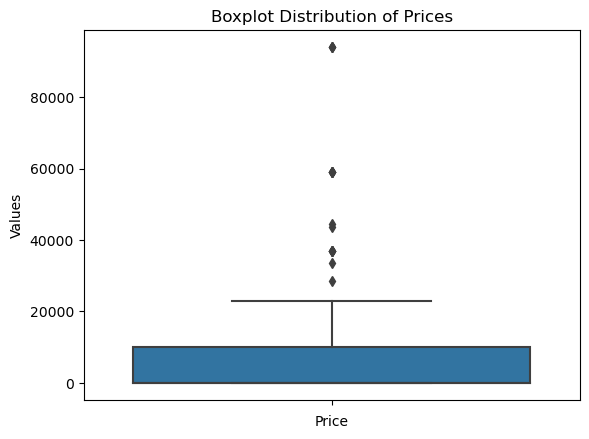

In [38]:
sns.boxplot(data =df, y = 'Shipping Prices')
plt.title('Boxplot Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Values')

plt.show()